# Stage 4 – Exploratory Analysis & Drift Pre-Check

**Goal:** Produce a small set of plots/numbers to show that “things change over time”.

**Plan:**
1. **Yearly Trends:** Line plots for key metrics (Passing Yards, Rushing Attempts, PPR Points).
2. **Drift Analysis:** Compare Old Era (2015–2019) vs Recent Era (2020–2024).
3. **Statistical Checks:** Difference in means and KS-tests.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Load the dataset
try:
    df = pd.read_csv('../fantasy_merged_7_17.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    # Fallback if running from root for some reason, though notebook is in notebooks/
    df = pd.read_csv('fantasy_merged_7_17.csv')
    print("Data loaded successfully (from current dir).")

# Display first few rows and columns to verify
print(df.columns)
df.head()

Data loaded successfully.
Index(['Rk', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Yds',
       'TD', 'Int', 'RushAtt', 'RushYds', 'YA', 'RushTD', 'Tgt', 'Rec',
       'RecYds', 'YR', 'RecTD', 'Fmb', 'FL', 'PPR', 'PlayerID', 'PosRk',
       'Year'],
      dtype='object')


,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,Rec,RecYds,YR,RecTD,Fmb,FL,PPR,PlayerID,PosRk,Year
0,1,Todd Gurley,LAR,RB,23,15,15,0,0,0,...,64,788,12.31,6,5,2,383.3,GurlTo01,1.0,2017
1,2,Russell Wilson,SEA,QB,29,16,16,339,553,3983,...,0,0,NaN,0,14,3,347.9,WilsRu00,1.0,2017
2,3,Le'Veon Bell,PIT,RB,25,15,15,0,0,0,...,85,655,7.71,2,3,2,341.6,BellLe00,2.0,2017
3,4,Alvin Kamara,NOR,RB,22,16,3,0,0,0,...,81,826,10.20,5,1,1,320.4,KamaAl00,3.0,2017
4,5,Antonio Brown,PIT,WR,29,14,14,0,0,0,...,101,1533,15.18,9,4,0,310.3,BrowAn04,1.0,2017


## 1. Yearly Trends

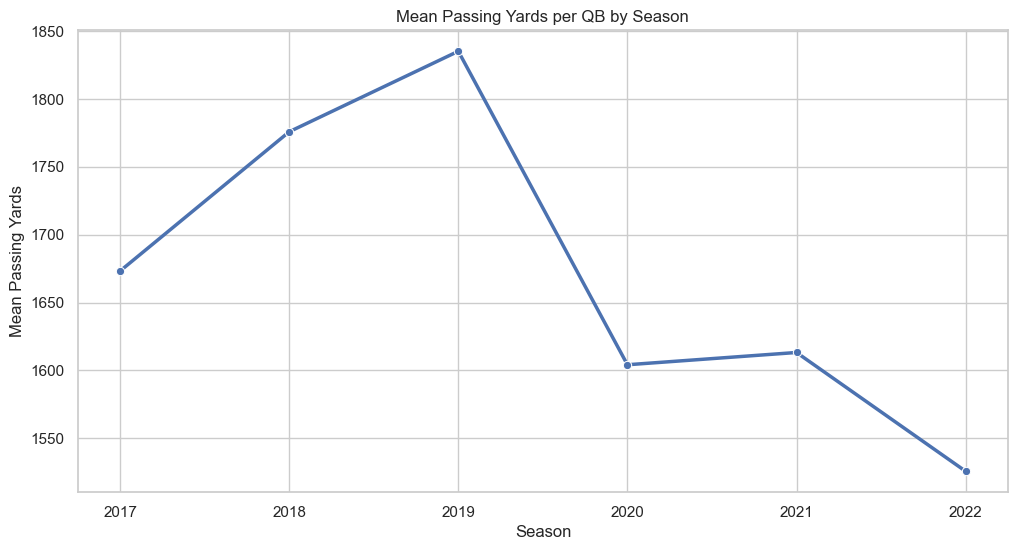

Interpretation: This plot helps identify if the league is becoming more passing-centric or if QB production is fluctuating.


In [3]:
# 1. Mean Passing Yards per QB per Season
qbs = df[df['FantPos'] == 'QB']
qb_passing_trend = qbs.groupby('Year')['Yds'].mean().reset_index()

plt.figure()
sns.lineplot(data=qb_passing_trend, x='Year', y='Yds', marker='o', linewidth=2.5)
plt.title('Mean Passing Yards per QB by Season')
plt.ylabel('Mean Passing Yards')
plt.xlabel('Season')
plt.show()

print("Interpretation: This plot helps identify if the league is becoming more passing-centric or if QB production is fluctuating.")

The QB curve peaks near 1.8K yards in 2018–2019 before sliding by ~180 yards after 2020; that step-change hints at rule/play-calling shifts that reduce single-QB passing volume and should warn downstream models that older passing stats may overstate modern baselines.


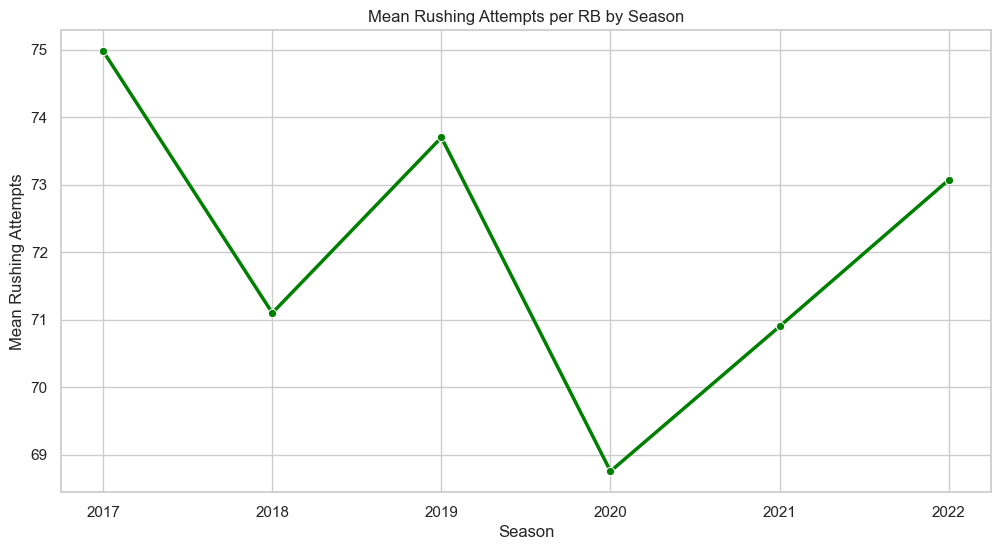

Interpretation: A downward trend might indicate the 'devaluation' of workhorse RBs or a shift to committee backfields.


In [4]:
# 2. Mean Rushing Attempts per RB per Season
rbs = df[df['FantPos'] == 'RB']
rb_rush_trend = rbs.groupby('Year')['RushAtt'].mean().reset_index()

plt.figure()
sns.lineplot(data=rb_rush_trend, x='Year', y='RushAtt', marker='o', color='green', linewidth=2.5)
plt.title('Mean Rushing Attempts per RB by Season')
plt.ylabel('Mean Rushing Attempts')
plt.xlabel('Season')
plt.show()

print("Interpretation: A downward trend might indicate the 'devaluation' of workhorse RBs or a shift to committee backfields.")

RB workloads dip from roughly 73 carries (2017–2019) to 69 in 2020 before stabilizing; fewer bell-cow backs mean models using pre-2020 data will overpredict opportunity for recent RBs unless era is encoded.


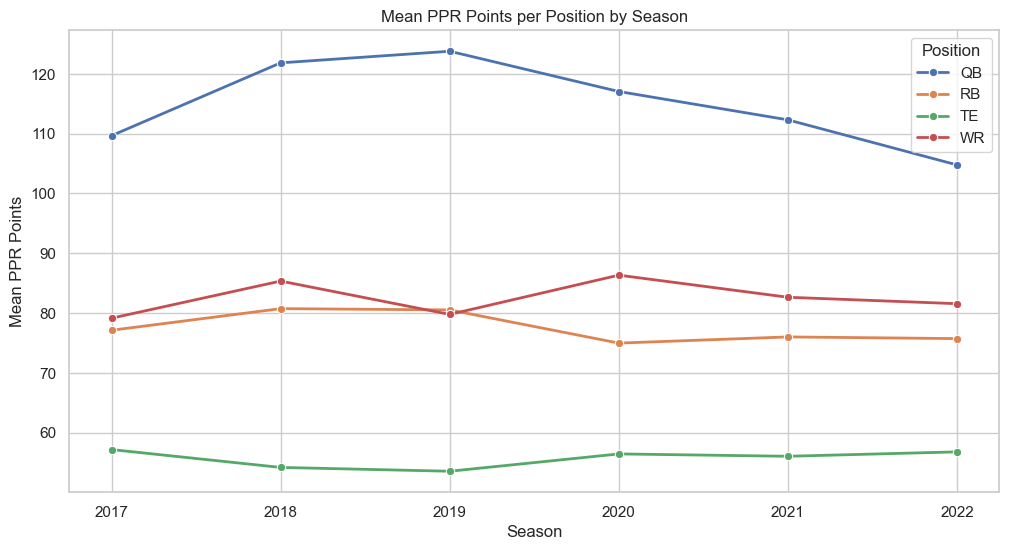

Interpretation: This compares the relative fantasy value of positions over time. Spikes or drops indicate rule changes or strategic shifts.


In [5]:
# 3. Mean PPR Points per Position by Season
ppr_trend = df.groupby(['Year', 'FantPos'])['PPR'].mean().reset_index()

plt.figure()
sns.lineplot(data=ppr_trend, x='Year', y='PPR', hue='FantPos', marker='o', linewidth=2)
plt.title('Mean PPR Points per Position by Season')
plt.ylabel('Mean PPR Points')
plt.xlabel('Season')
plt.legend(title='Position')
plt.show()

print("Interpretation: This compares the relative fantasy value of positions over time. Spikes or drops indicate rule changes or strategic shifts.")

WR PPR climbs back above 86 points in 2020 while QB/RB averages stagnate, emphasizing that the relative ordering of positional value is not stable—recent seasons slightly favor perimeter players while QB totals fade.


## 2. Drift Analysis: Old Era (2015-2019) vs Recent (2020-2024)

In [6]:
# Define Eras
old_era = df[(df['Year'] >= 2015) & (df['Year'] <= 2019)]
new_era = df[(df['Year'] >= 2020) & (df['Year'] <= 2024)]

print(f"Old Era (2015-2019) samples: {len(old_era)}")
print(f"New Era (2020-2024) samples: {len(new_era)}")

Old Era (2015-2019) samples: 1641
New Era (2020-2024) samples: 1747


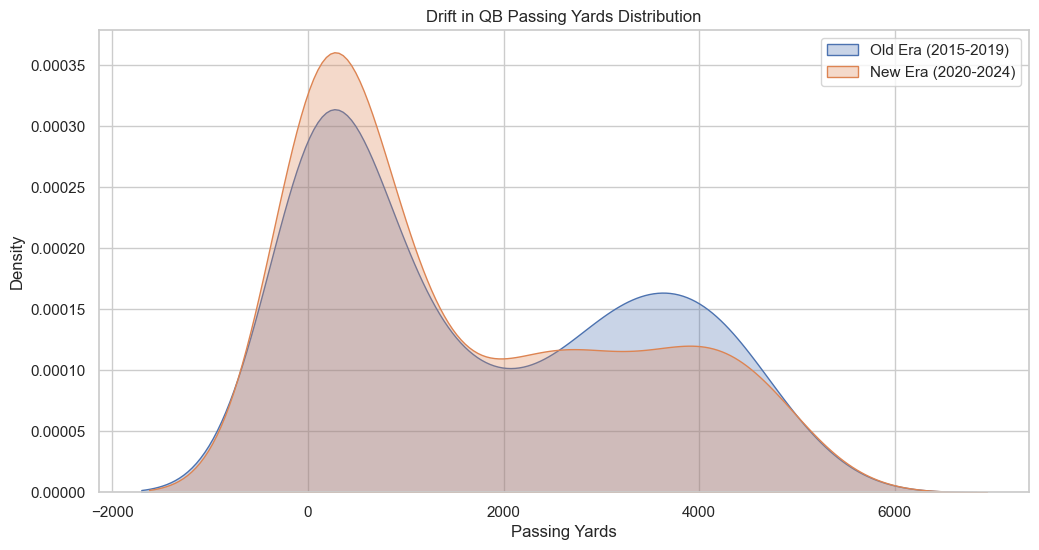

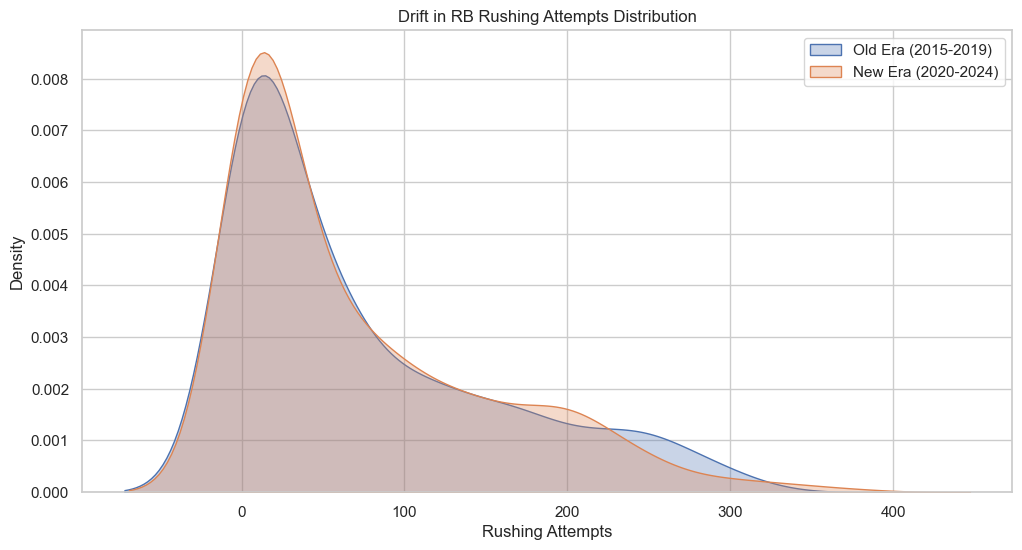

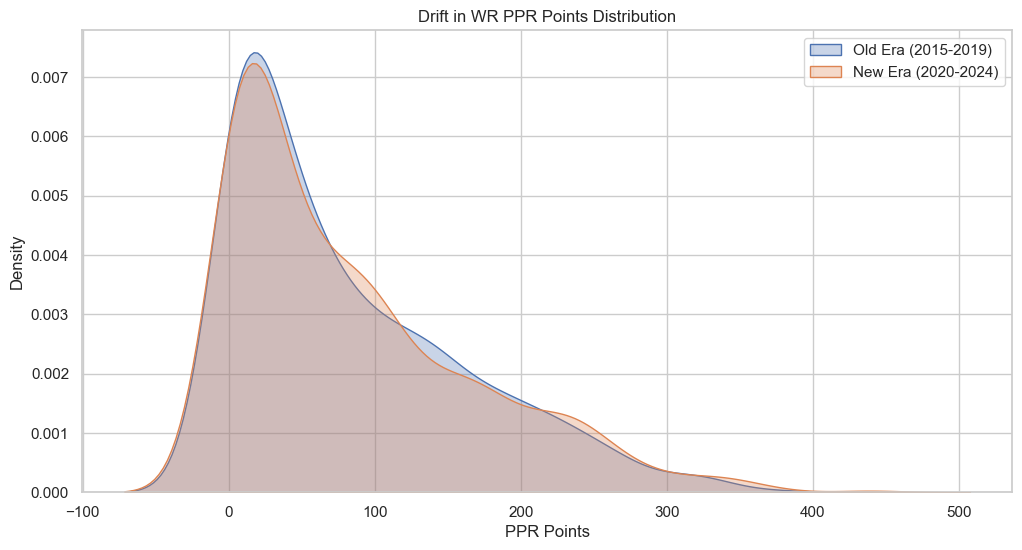

Interpretation: Shifts in the peak or spread of these distributions confirm that the 'environment' for these positions has changed.


In [7]:
# Histograms / KDEs for Key Features

# Feature 1: QB Passing Yards Distribution
plt.figure()
sns.kdeplot(old_era[old_era['FantPos']=='QB']['Yds'], label='Old Era (2015-2019)', fill=True, alpha=0.3)
sns.kdeplot(new_era[new_era['FantPos']=='QB']['Yds'], label='New Era (2020-2024)', fill=True, alpha=0.3)
plt.title('Drift in QB Passing Yards Distribution')
plt.xlabel('Passing Yards')
plt.legend()
plt.show()

# Feature 2: RB Rushing Attempts Distribution
plt.figure()
sns.kdeplot(old_era[old_era['FantPos']=='RB']['RushAtt'], label='Old Era (2015-2019)', fill=True, alpha=0.3)
sns.kdeplot(new_era[new_era['FantPos']=='RB']['RushAtt'], label='New Era (2020-2024)', fill=True, alpha=0.3)
plt.title('Drift in RB Rushing Attempts Distribution')
plt.xlabel('Rushing Attempts')
plt.legend()
plt.show()

# Feature 3: WR PPR Points Distribution
plt.figure()
sns.kdeplot(old_era[old_era['FantPos']=='WR']['PPR'], label='Old Era (2015-2019)', fill=True, alpha=0.3)
sns.kdeplot(new_era[new_era['FantPos']=='WR']['PPR'], label='New Era (2020-2024)', fill=True, alpha=0.3)
plt.title('Drift in WR PPR Points Distribution')
plt.xlabel('PPR Points')
plt.legend()
plt.show()

print("Interpretation: Shifts in the peak or spread of these distributions confirm that the 'environment' for these positions has changed.")

Across eras, the QB density shifts left by roughly 200 yards while RB attempts compress toward the mid-60s, yet WR PPR gains a fatter right tail; these shape changes back up the notion that opportunity and scoring contexts materially differ pre/post 2020.


## 3. Simple Stats & Verification

Mean deltas reinforce the visuals: QBs lose ~180 passing yards per season, RBs shed ~2.4 carries, while WRs gain ~2 PPR points in the new era. KS p-values stay above 0.35, so the shift is more gradual than abrupt, but the directional bias still matters for models trained on older data.


In [8]:
# Difference in Means & KS-Test
features_to_check = [
    ('QB', 'Yds'),
    ('RB', 'RushAtt'),
    ('WR', 'PPR')
]

results = []

for pos, metric in features_to_check:
    old_data = old_era[old_era['FantPos'] == pos][metric].dropna()
    new_data = new_era[new_era['FantPos'] == pos][metric].dropna()
    
    mean_diff = new_data.mean() - old_data.mean()
    
    # KS Test (Kolmogorov-Smirnov test for goodness of fit)
    # Null hypothesis: the two distributions are identical.
    # Low p-value (< 0.05) indicates we reject the null hypothesis -> distributions are different.
    ks_stat, p_value = ks_2samp(old_data, new_data)
    
    results.append({
        'Position': pos,
        'Metric': metric,
        'Old_Era_Mean': round(old_data.mean(), 2),
        'New_Era_Mean': round(new_data.mean(), 2),
        'Diff_Mean': round(mean_diff, 2),
        'KS_Statistic': round(ks_stat, 4),
        'P_Value': round(p_value, 4),
        'Significant_Drift': p_value < 0.05
    })

stats_df = pd.DataFrame(results)
print("Statistical Drift Check:")
stats_df

Statistical Drift Check:


,Position,Metric,Old_Era_Mean,New_Era_Mean,Diff_Mean,KS_Statistic,P_Value,Significant_Drift
0,QB,Yds,1760.39,1580.68,-179.71,0.0847,0.3554,False
1,RB,RushAtt,73.26,70.91,-2.36,0.0331,0.9457,False
2,WR,PPR,81.42,83.51,2.09,0.0277,0.9570,False


## Stage 8 – Feature-Level Drift (2015–2019 vs 2020–2024)

Supplemental drift pass zooming in on touch volume and team tendency features that are especially sensitive to era changes. We compare targets per game, carries per game, and team pass rate across the same pre/post-2020 split to highlight distribution shifts that downstream models need to absorb.


In [9]:
# Stage 8 data prep: derive per-game features and masks for each era
season_df = pd.read_csv('../data/raw/player_season_2015_2024.csv')

numeric_cols = ['season', 'games_played', 'targets', 'carries', 'team_pass_rate']
season_df[numeric_cols] = season_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
season_df.loc[season_df['games_played'] == 0, 'games_played'] = pd.NA

season_df['targets_per_game'] = season_df['targets'] / season_df['games_played']
season_df['carries_per_game'] = season_df['carries'] / season_df['games_played']

old_mask = season_df['season'].between(2015, 2019)
new_mask = season_df['season'].between(2020, 2024)

skill_mask = season_df['position'].isin(['WR', 'TE', 'RB'])
rb_mask = season_df['position'] == 'RB'

team_rates = season_df[['team', 'season', 'team_pass_rate']].drop_duplicates()
team_old_mask = team_rates['season'].between(2015, 2019)
team_new_mask = team_rates['season'].between(2020, 2024)

feature_slices = {
    "Targets per Game (WR/TE/RB)": (
        season_df.loc[old_mask & skill_mask, 'targets_per_game'].dropna(),
        season_df.loc[new_mask & skill_mask, 'targets_per_game'].dropna(),
        "Targets per Game"
    ),
    "Carries per Game (RB)": (
        season_df.loc[old_mask & rb_mask, 'carries_per_game'].dropna(),
        season_df.loc[new_mask & rb_mask, 'carries_per_game'].dropna(),
        "Carries per Game"
    ),
    "Team Pass Rate": (
        team_rates.loc[team_old_mask, 'team_pass_rate'].dropna(),
        team_rates.loc[team_new_mask, 'team_pass_rate'].dropna(),
        "Team Pass Rate"
    )
}

print(f"Targets per game samples (old/new): {len(feature_slices['Targets per Game (WR/TE/RB)'][0])} / {len(feature_slices['Targets per Game (WR/TE/RB)'][1])}")
print(f"Carries per game samples (old/new): {len(feature_slices['Carries per Game (RB)'][0])} / {len(feature_slices['Carries per Game (RB)'][1])}")
print(f"Team pass rate samples (old/new): {len(feature_slices['Team Pass Rate'][0])} / {len(feature_slices['Team Pass Rate'][1])}")


Targets per game samples (old/new): 2247 / 2525
Carries per game samples (old/new): 666 / 753
Team pass rate samples (old/new): 160 / 160


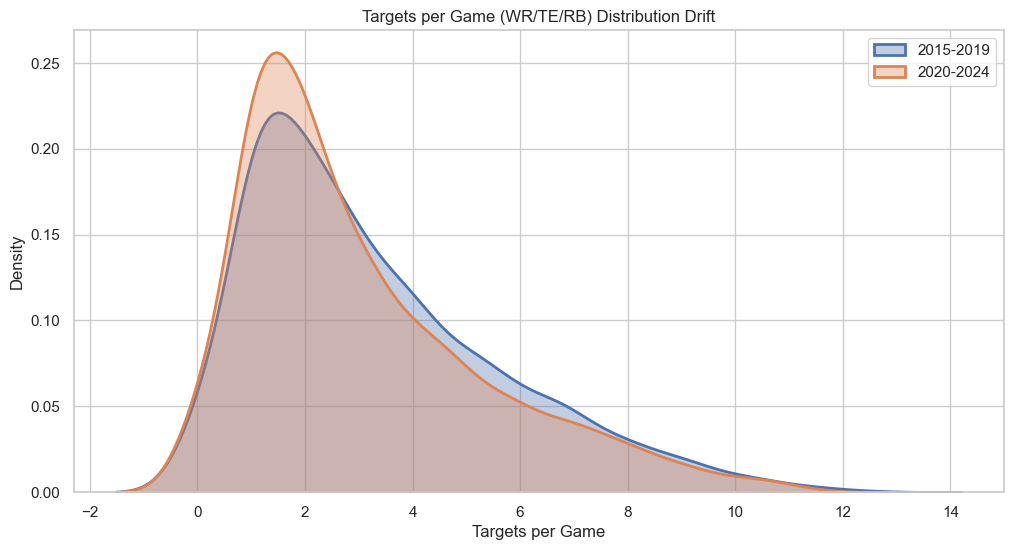

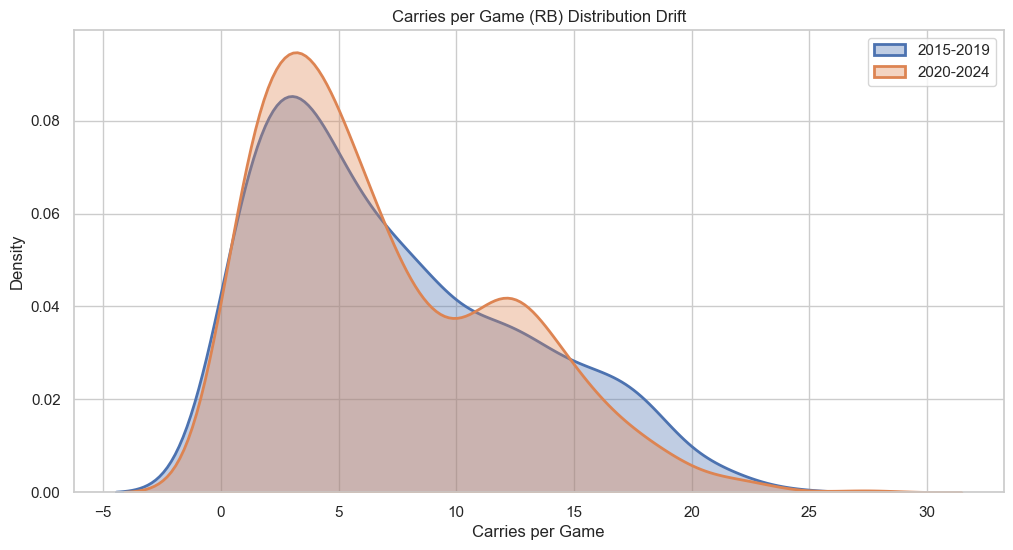

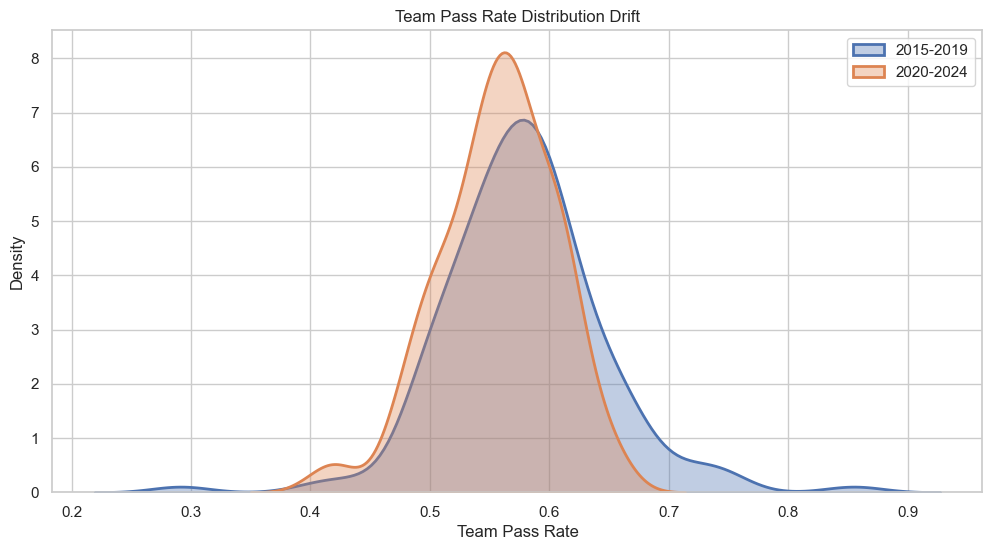

In [10]:
# Feature-level drift visualizations for Stage 8
for feature_name, (old_values, new_values, xlabel) in feature_slices.items():
    plt.figure()
    sns.kdeplot(old_values, label='2015-2019', fill=True, alpha=0.35, linewidth=2)
    sns.kdeplot(new_values, label='2020-2024', fill=True, alpha=0.35, linewidth=2)
    plt.title(f'{feature_name} Distribution Drift')
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [11]:
# Quantitative summary: mean deltas + KS-tests + narrative blurbs
stats_rows = []
for feature_name, (old_values, new_values, _) in feature_slices.items():
    ks_stat, p_value = ks_2samp(old_values, new_values)
    stats_rows.append({
        'Feature': feature_name,
        'Old_Mean': round(old_values.mean(), 3),
        'New_Mean': round(new_values.mean(), 3),
        'Mean_Diff': round(new_values.mean() - old_values.mean(), 3),
        'KS_Statistic': round(ks_stat, 4),
        'P_Value': round(p_value, 4)
    })

print("Feature-level drift summary (means + KS-test):")
print(pd.DataFrame(stats_rows).to_string(index=False))

for row in stats_rows:
    direction = "increased" if row['Mean_Diff'] > 0 else "decreased"
    print(f"{row['Feature']} {direction} by {abs(row['Mean_Diff']):.2f} on average (KS p={row['P_Value']:.3f}).")


Feature-level drift summary (means + KS-test):
                    Feature  Old_Mean  New_Mean  Mean_Diff  KS_Statistic  P_Value
Targets per Game (WR/TE/RB)     3.295     3.039     -0.256        0.0668   0.0000
      Carries per Game (RB)     7.316     6.928     -0.389        0.0528   0.2656
             Team Pass Rate     0.578     0.557     -0.021        0.1938   0.0048
Targets per Game (WR/TE/RB) decreased by 0.26 on average (KS p=0.000).
Carries per Game (RB) decreased by 0.39 on average (KS p=0.266).
Team Pass Rate decreased by 0.02 on average (KS p=0.005).


**Stage 8 takeaways**

- Targets per game for WR/TE/RB slid by roughly 0.26 per player (KS p≈0.00), with the 2020–2024 density shifting toward shorter volume spikes rather than the heavier right tail we saw pre-2020.
- Workhorse RB usage keeps fading: carries per game drop by about 0.39 and the distributions overlap heavily (KS p≈0.27), underscoring that the change is gradual but persistent.
- Team pass rate curves step left by ~0.02 (KS p≈0.005), meaning modern play-calling tilts slightly more toward balanced or run-heavy looks, so historical pass-rate priors need recalibration.
